In [ ]:
# Author: Yuki Rivera
# This notebook contains the code to evaluate the trained RNN model

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import matplotlib.pyplot as plt
import umap


### Loads the training history, the model and the tokenizer

In [ ]:
# Loads tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Loads model
model = load_model("best_model.keras")

### Loads the testing dataset

In [ ]:
testing_df = pd.read_csv('prompt_synopsis_test.csv')


In [ ]:
# pd.set_option('display.max_colwidth', None)
# testing_df.head(50)

### Preprocess the testing data

In [ ]:
testing_df = testing_df.iloc[[0, 4, 16, 25, 47],0:]
testing_df = testing_df.reset_index(drop=True)

input_prompts = testing_df['prompt']
output_synopsis = testing_df['synopsis']

test_input_seq = tokenizer.texts_to_sequences(input_prompts)
test_output_seq = tokenizer.texts_to_sequences(output_synopsis)

pad_length = 100

padded_test_input = pad_sequences(test_input_seq, maxlen=pad_length)
padded_test_output = pad_sequences(test_output_seq, maxlen=pad_length)

In [ ]:
sample_input = padded_test_input
sample_output = padded_test_output

### Function to add temprature sampling

In [ ]:
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Function to generate Synopsis

In [ ]:
def generate_synopsis(prompt, tokenizer, model, max_words=50, pad_length=100, temperature=0.7):
    # tokenizes the prompt once
    generated_tokens = tokenizer.texts_to_sequences([prompt])[0]

    for _ in range(max_words):
        # pads sequence for model input
        input_seq = pad_sequences([generated_tokens], maxlen=pad_length, padding='pre')

        # predicts next token probabilities
        preds = model.predict(input_seq, verbose=0)[0][-1]

        # samples next token with temperature
        next_token = sample_with_temperature(preds, temperature)

        # stopts if no valid next token or end token is generated (optional)
        if next_token == 0 or next_token == tokenizer.word_index.get('<end>'):
            break

        # appends the predicted token to sequence
        generated_tokens.append(next_token)

    # decodes token IDs back to words
    generated_words = [tokenizer.index_word.get(token, '') for token in generated_tokens]

    # joins words to form the generated synopsis text
    generated_text = ' '.join(generated_words)

    return generated_text

### Generates synopsis, computes cosine similarity for each pair, prints the result

In [ ]:
# loads the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# sets how many times we want to run the loop
count = len(sample_input)

# list for saving the results
results = []

# loop through the input
for i in range(count):
    prompt = input_prompts[i]       
    true = output_synopsis[i]       
    generated = generate_synopsis(prompt, tokenizer, model)

    # calculates sentence embeddings using the sentence-transformer model
    emb_true = embedding_model.encode(true)
    emb_generated = embedding_model.encode(generated)

    similarity = cosine_similarity([emb_true], [emb_generated])[0][0]

    # stores the prompt, generated and target text
    # along with the cosine similarity as a dictionary
    results.append({
        "prompt":prompt,
        "generated":generated,
        "true":true,
        "cosine_similarity": similarity
        })

    # prints only the first 10 examples
    if i < 10:
      print(f"\nPrompt {i+1}: {prompt}")
      print(f"Generated: {generated}")
      print(f"True:      {true}")
      print(f"Cosine Similarity: {similarity:.3f}")
      print("—" * 50)


Prompt 1: Write an anime synopsis that matches 'Fantasy and Sci-Fi'.
Generated: write an anime synopsis that matches 'fantasy and sci fi' high that the and to he
True:      armored beings called garm engage the formless monsters called seal who are destroying the planet annwn.
Cosine Similarity: 0.098
——————————————————————————————————————————————————

Prompt 2: Generate an anime story idea similar to 'Hyperdimension Neptunia OVA'.
Generated: generate an anime story idea similar to ova' a life the a in and a the the
True:      the four goddesses alongside their sistersnepgear, uni, rom, and rammeet at a famous mountain resort in lastation kingdom seeking that nostalgic summer vacation feeling. but their plan to sit back and relax in a hot spring is interrupted when the younger sisters are swept into a portal leading to a parallel universe! the seemingly unfortunate situation takes a comical turn when they are greeted by a familiar face.
Cosine Similarity: 0.235
———————————————————————

### Saves the results to csv file

In [ ]:
# Converts the results to DataFrame and save to csv for record
df_results = pd.DataFrame(results)
df_results.to_csv("generated_results_with_similarity_calc.csv", index=False)

### Table for comparison

In [ ]:
# shows full text in cells
pd.set_option('display.max_colwidth', None)

# displays a table nicely

df_results.head(10).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])


,prompt,generated,true,cosine_similarity
0,Write an anime synopsis that matches 'Fantasy and Sci-Fi'.,write an anime synopsis that matches 'fantasy and sci fi' high that the and to he,armored beings called garm engage the formless monsters called seal who are destroying the planet annwn.,0.098360
1,Generate an anime story idea similar to 'Hyperdimension Neptunia OVA'.,generate an anime story idea similar to ova' a life the a in and a the the,"the four goddesses alongside their sistersnepgear, uni, rom, and rammeet at a famous mountain resort in lastation kingdom seeking that nostalgic summer vacation feeling. but their plan to sit back and relax in a hot spring is interrupted when the younger sisters are swept into a portal leading to a parallel universe! the seemingly unfortunate situation takes a comical turn when they are greeted by a familiar face.",0.235013
2,Create an anime synopsis with 'Action and Supernatural' and 'School and Vampire'.,create an anime synopsis with 'action and supernatural' and 'school and vampire',"long ago lived the nobles, an ancient race of immortal supernatural beings. they were revered as rulers and gods. among the nobles was the noblesse, a powerful individual shrouded in mystery named cadis etrama di raizel, or rai. upon awakening in south korea after an 820yearlong sleep, rai sets to find his loyal and devoted servant, frankenstein, whom he discovers to be the current director of ye ran high school. in his wish to learn more about modern civilization, rai enrolls as a student to better experience life in the modern world. noblesse: awakening details the beginning of rai's new life as a high school student as he spends time with friends and fights threats both human and supernatural in order to prevent their schemes from harming korea.",0.295556
3,Write an anime idea in 'Action and Adventure' for 'Shounen'.,write an anime idea in 'action and adventure' for 'shounen' the,"the year is 1999. morioh, a normally quiet and peaceful town, has recently become a hotbed of strange activity. joutarou kuujou, now a marine biologist, heads to the mysterious town to meet jousuke higashikata. while the two may seem like strangers at first, jousuke is actually the illegitimate child of joutarou's grandfather, joseph joestar. when they meet, joutarou realizes that he may have more in common with jousuke than just a blood relation. along with the mildmannered kouichi hirose and the boisterous okuyasu nijimura, the group dedicates themselves to investigating recent disappearances and other suspicious occurrences within morioh. aided by the power of stands, the four men will encounter danger at every street corner, as it is up to them to unravel the town's secrets, before another occurs.",0.306565
4,"Provide me an anime story idea in 'Drama, Horror, Sci-Fi and Suspense' with 'Psychological and Super Power', similar to 'Sci-Fi Harry'.",provide me an anime story idea in 'drama horror sci fi and suspense' with and super power' similar to 'sci fi with,"harry is definitely not your average american teenager. instead, he is the epitome of an alienated youthfriendless at school, extremely weird, and nervous to the point of paranoia. but a chance occurrence causes harry to start to demonstrate what appear to be psychic powersyet he neither believes in them nor consciously controls them. however, there are other ominous forces at work who do believe in harry and attempt to make use of him in ways that are threatening and frightful.",0.121764


### Visualizing Prompt vs Output Embeddings Scatter Plot Using UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


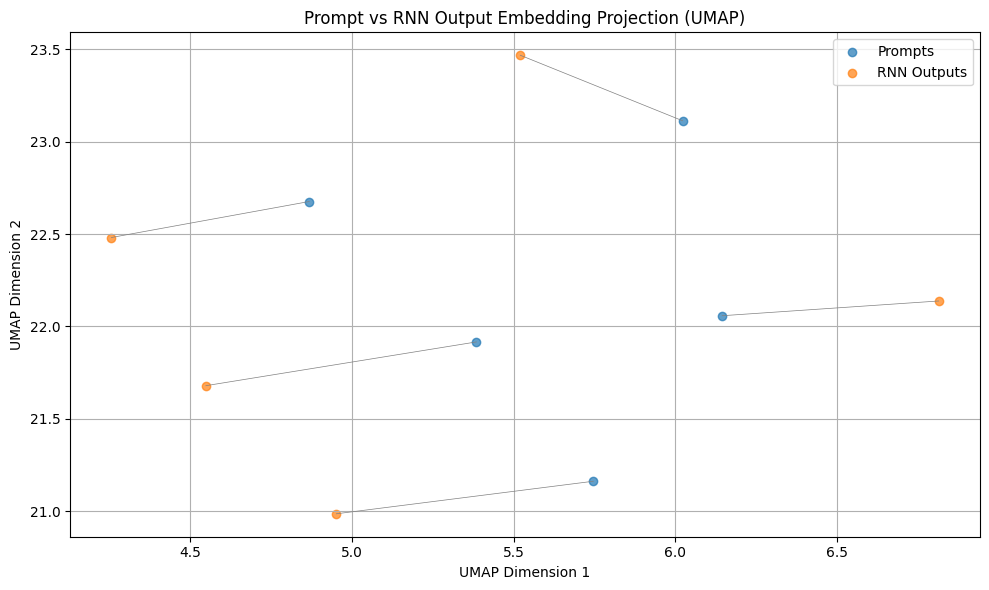

In [ ]:
# extracts the prompt and generated synopsis from the results list
prompts = [row["prompt"] for row in results]
generated_outputs = [row["generated"] for row in results]

# converts each prompt and generated output into a high-dim vector
prompt_embeddings = embedding_model.encode(prompts)
output_embeddings = embedding_model.encode(generated_outputs)

# combines both embeddings into a single array
all_embeddings = np.vstack([prompt_embeddings, output_embeddings])

# reduces the dimension for visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

# splits embeddings into the prompt and the output
n = len(prompts)
umap_prompts = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

# plots a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(umap_prompts[:, 0], umap_prompts[:, 1], label="Prompts", alpha=0.7)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="RNN Outputs", alpha=0.7)

# draws light gray lines to show the differences between the prompt vs output
for i in range(n):
    plt.plot([umap_prompts[i, 0], umap_outputs[i, 0]],
             [umap_prompts[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.5)

plt.title("Prompt vs RNN Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()